# Pressure Fluctuation Data

I include some details about the physics and numerics of the simulation that generated the data, in case you are curious. They are not necessary to analyse the data, at best they can come handy to understand the normalization. If you are not interested, you can skip this section.

## Why pressure fluctuations
Acoustic waves are produced any time there is a sudden change in vorticity in a compressible fluid. Over an airfoil, when the boundary layer crosses the trailing edge, the eddies in the flow get scattered, generating noise. While it is in principle possible to follow this line of reasoning, it is more common in the aeroacoustics community to concentrate on the trace that these vorticies leave on the walls of the airfoil in terms of pressure fluctuations. The pressure fluctuation near the trailing edge generate sound waves that get scattered by the geometrical "singularity", getting amplified in the process. There exists an analytical model relating the turbulent pressure fluctuations on the wall and the acoustic fluctuations perceived by a far away observer, known as Amiet model:

$$
  S_{pp}(\mathbb{x}, \omega) \propto \bigg\vert\underbrace{\mathcal L\left(\frac{\omega c}{2U_c}, \frac{kx_2}{S_0}\right)}_\text{transfer function}\bigg\vert^2\underbrace{\Phi_{pp}(\omega)\ell_y\left(\omega, \frac{kx_2}{U_c}\right)}_\text{source statistics}\;,
$$

where $S_{pp}$ is the acoustic pressure power spectral density percieved at the point $\mathbb{x}$, $\Phi_{pp}$ is the wall pressure power spectral density, $\ell_y$ the correlation length along the span, $k$ the acoustic wavenumber, $U_c$ the convection speed, $c$ the chord of the airfoil and $S_0 = x_1^2+(1-M^2)(x_2^2+x_3^2)$, with $M$  the Mach number of the incoming flow. While such a model greatly simplifies the task of propagating the acoustics from the airfoil's surface to the far-field, computing $\Phi_{pp}$ and $\ell_y$ is still a challenge in the absence of experimental or numerical data.

## Physical details of the simulation
We analyse here the pressure fluctuation data issued from a Direct Numerical Simulation (DNS) of the flow around a Controlled Diffusion (CD) airfoil at reynolds number  $Re=U_\infty c/\nu=150.000$, Mach number $M=U_\infty/c_s=0.25$ and angle of attack $\alpha=15^\circ$ ($U_\infty$ is the inlet velocity, $c$ the airfoil chord, $\nu$ the dynamic viscosity and $c_s = \sqrt{\gamma R T}$ the speed of sound, with $\gamma$ the heat capacity ratio of air, $R$ its specific gas constant and $T$ the background temperature). To match some experimetal conditions at a reasonable computational cost, the fluid is simulated as if it was cryogenic (compressible solvers work better at moderate Mach numbers, compared to very low ones, where the flow can be safely considered incompressible. The accepted limit is around $M=0.3$). While semi-analytical models exist for $\Phi_{pp}$, none is precise in all flow conditions, and little research has been devoted to estimating the coherence length $\ell_y$. 

**The idea is to use high-fidelity numerical simulations to train a generative model of the probability distribution of the pressure fluctuations, which would allow to let go of expensive simulations or experiments in pre-design stages. Once a generative model is put in place, the statistics $\Phi_{pp}$ and $\ell_y$ can be computed from its realizations**

In [1]:
R = 287.05 # gas constant for dry air  [J/(kg*K)]
rho_ref = 1.225     # experiments density [kg/m^3]
U_ref = 16          # experiments velocity [m/s]
cref = 0.1356       # airfoil chord [m]
p_dyn = rho_ref*U_ref**2 # dynamic pressure [Pa]
re = 1.5e5 # Reynolds number
M = 0.25 # Mach number
c_sound = U_ref / M 
tref = c_sound**2 / (1.4 * R) # reference temperature
p_ref = rho_ref * R * tref
nu = U_ref * cref / re # kinematic viscosity

print(f"+{'-'*20}+{'-'*20}+")
print(f"| {'Variable':<18} | {'Value':<18} |")
print(f"+{'-'*20}+{'-'*20}+")
print(f"| {'Re':<18} | {re:>18.2e} |")
print(f"| {'M':<18} | {M:>18.2f} |")
print(f"| {'AoA α':<18} | {15.0:>18.2f} |")
print(f"| {'ρ ref':<18} | {rho_ref:>18.2f} |")
print(f"| {'U ref':<18} | {U_ref:>18.2f} |")
print(f"| {'c ref':<18} | {cref:>18.2f} |")
print(f"| {'p dyn':<18} | {p_dyn:>18.2f} |")
print(f"| {'c sound':<18} | {c_sound:>18.2f} |")
print(f"| {'T ref':<18} | {tref:>18.2f} |")
print(f"| {'p ref':<18} | {p_ref:>18.2f} |")
print(f"| {'ν':<18} | {nu:>18.2e} |")
print(f"+{'-'*20}+{'-'*20}+")

+--------------------+--------------------+
| Variable           | Value              |
+--------------------+--------------------+
| Re                 |           1.50e+05 |
| M                  |               0.25 |
| AoA α              |              15.00 |
| ρ ref              |               1.23 |
| U ref              |              16.00 |
| c ref              |               0.14 |
| p dyn              |             313.60 |
| c sound            |              64.00 |
| T ref              |              10.19 |
| p ref              |            3584.00 |
| ν                  |           1.45e-05 |
+--------------------+--------------------+


## Numerical details of the simulation
We simulated a thin section of the CD airfoil with periodic boudary conditions on the sides to limit the computational cost. This effectively result is a simulation that reproduces the conditions of an infinite straight blade. The other boundary conditions on the sides of the domain are set by using the solution of a lower fidelity simulation (Reynolds Averaged Navier Stokes, or RANS) to reproduce the conditions of a reference set of experiments. The walls of the airfoil are considered adiabatic. The velocity is set to zero there (no-slip condition). The domain is discretized by using a Chimera approach: the background is divided into regular exahedral cells, while the fields immediately around the airfoil are discretized on a body-fitted grid. The fields are then matched where the two meshes overlap. The wake is also refined using the same strategy, since in other numerical campaigns some noise sources where identified in this region. You can see the meshing strategy in the figure. In total, the simulation includes 297 million cells.

![domain](./figures/domain.png)

The solver used to solve the compressible Navier-Stokes equations is the code HiPSTAR, which is specifically tailored to handle similar cases with great efficiency. The gradients in the $x$ and $y$ directions are discretized using a fouth-order centered finite difference scheme, while the $z$ direction is handled using a spectral method, leveraging the periodicity of the domain. The time integration is carried out using an explicit 5 steps of order 4 ultra-low storage Runge-Kutta integrator. The extreme precision in the simulation is imposed by the physics of the problem at hand: acoustic fluctuations can be four order of magnitude smaller than turbulent fluctuations. If care is not used, the artificial viscosity induced by the solver itself would just totally eliminate all the acoustic fluctuations by dissipation.  All in all, the simulation is extremely precise, at the state of the art in the aeroacoustic community. 

## The data
The data is composed of two files:
 * `SherFWHsolid1_grid.h5`: contains the position of all the nodes of the surface of the airfoil;
 * `SherFWHsolid1_p_raw_data_250.h5`: contains the pressure fluctuations history at all points, as well as the average pressure field.

The data for `x`, `y` and `z` coordinates, as well as `pressure_mean` are datasets of shape `(3000, 192)`, where the first dimension is the number of points around the airfoil (the tangential coordinate on the surface of the airfoil), ordered counter clock-wise starting from the trailing edge, and the second is the number of points in the span-wise direction. The `pressure` dataset is of shape `(15200, 3000, 192)`, where the first dimension is the number of time snapshots. The files are all written in `h5` format and handled by the package `h5py`. It is not advisable to try to load the entire `pressure` dataset in memory, because it is quite large (around 4Gb).

### A note about the normalization
All data is adimensionalized. This is standard practice in the fluid mechanics community because it makes comparisons between results much easier. The nomalizations used are (starred quantities are dimensional):
* $u = u^*/U_\infty$;
* $L = L^*/c$ for all lengths;
* $p = p/(0.5\rho_\infty U_\infty^2)$;
* $t = t^* U_\infty/c$ ($c/U_\infty$ is known as convective time).

In [2]:
import os

import h5py

from functools import partial

import numpy as np

import matplotlib.pyplot as plt
# Matplotlib global settings
plt.style.use('style.mplstyle')

x
<class 'h5py._hl.dataset.Dataset'>
... of shape (3000, 192)
y
<class 'h5py._hl.dataset.Dataset'>
... of shape (3000, 192)
z
<class 'h5py._hl.dataset.Dataset'>
... of shape (3000, 192)
max z = 0.19895833730697632


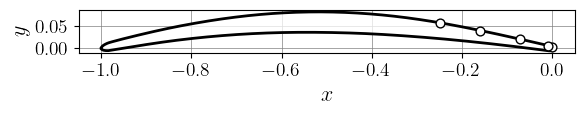

In [4]:
data_dir = "./data/"
mesh_file = os.path.join(data_dir, "SherFWHsolid1_grid.h5")
data_file = os.path.join(data_dir, "SherFWHsolid1_p_raw_data_250.h5")

def print_name(name):
    print(name)

def print_info(name, object):
    print(name)
    print(type(object))
    try:
        print(f'... of shape {object.shape}')
    except AttributeError:
        pass

def rotate_airfoil(x,y,alpha_deg):
    alpha = alpha_deg*np.pi/180
    x_rot = x*np.cos(alpha) - y*np.sin(alpha)
    y_rot = x*np.sin(alpha) + y*np.cos(alpha)
    return x_rot, y_rot


with h5py.File(mesh_file, "r") as f:
    f.visititems(print_info)
    x = f['x']
    y = f['y']
    z = f['z']

    # rotate airfoil
    aoa = 15.0
    x,y = rotate_airfoil(x,y,aoa)

    # separate suction and pressure sides
    idx = np.argmin(x, axis=0)[0]

    # suction side
    x_ss = x[idx:]
    y_ss = y[idx:]
    z_ss = z[idx:]

    # pressure side
    x_ps = x[:idx]
    y_ps = y[:idx]
    z_ps = z[:idx]

print(f'max z = {np.max(z_ps)}')
# plot geometry
dx = 100

fig, ax = plt.subplots()

ax.fill(x[:,0], y[:,0], color='white', alpha=0.75, zorder=2)

ax.plot(x_ss[:,0], y_ss[:,0], color='k')
ax.plot(x_ps[:,0], y_ps[:,0], color='k')
for i in range(1,6):
    ax.scatter(x_ss[-dx*i,0], y_ss[-dx*i,0], s=40, c='white', zorder=5, edgecolors='k')
ax.set_aspect('equal')
ax.grid(which='major', linewidth=0.5, color='gray', zorder=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()



The figure shows the geometry of the airfoil on the $x-y$ plane. The white points indicate the locations where the pressure will be analysed later.

In [4]:

with h5py.File(data_file, "r") as f:
    f.visititems(print_info)
    print(f'+{"-"*20}+{"-"*20}+')
    print(f'| {"Name":<18} | {"Value":>18} |')
    print(f'+{"-"*20}+{"-"*20}+')
    print(f'| {"Timesteps":<18} | {f["N"][()]:>18} |')
    print(f'| {"Δt sampling":<18} | {f["T_s"][()]:>18.2e} |')
    print(f'| {"Sampling frequency":<18} | {f["f_s"][()]:18.3f} |')
    print(f'| {"Total time":<18} | {f["N"][()] * f["T_s"][()]:>18.3f} |')
    print(f'+{"-"*20}+{"-"*20}+')


    p_avg = f['pressure_mean']
    p = f['pressure']

    spacing = 941
    p_avg_ss = p_avg[idx:]
    p_ss0 = p[0,idx:,:] - p_avg[idx:,:]
    p_ss1 = p[spacing,idx:,:] - p_avg[idx:,:]
    p_ss2 = p[spacing*2,idx:,:] - p_avg[idx:,:]
    p_ss3 = p[spacing*3,idx:,:] - p_avg[idx:,:]
    p_ss4 = p[spacing*4,idx:,:] - p_avg[idx:,:]

    n_steps = 1500
    p_te0 = p[:n_steps,-dx,:] - p_avg[-dx,:]
    p_te1 = p[:n_steps,-dx*2,:] - p_avg[-dx*2,:]
    p_te2 = p[:n_steps,-dx*3,:] - p_avg[-dx*3,:]
    p_te3 = p[:n_steps,-dx*4,:] - p_avg[-dx*4,:]
    p_te4 = p[:n_steps,-dx*5,:] - p_avg[-dx*5,:]

    dt = f['T_s'][()] # adimensional time step

N
<class 'h5py._hl.dataset.Dataset'>
... of shape ()
T_s
<class 'h5py._hl.dataset.Dataset'>
... of shape ()
f_s
<class 'h5py._hl.dataset.Dataset'>
... of shape ()
pressure
<class 'h5py._hl.dataset.Dataset'>
... of shape (15200, 3000, 192)
pressure_mean
<class 'h5py._hl.dataset.Dataset'>
... of shape (3000, 192)
timesteps
<class 'h5py._hl.dataset.Dataset'>
... of shape (15200,)
+--------------------+--------------------+
| Name               |              Value |
+--------------------+--------------------+
| Timesteps          |              15200 |
| Δt sampling        |           1.06e-03 |
| Sampling frequency |            941.176 |
| Total time         |             16.150 |
+--------------------+--------------------+


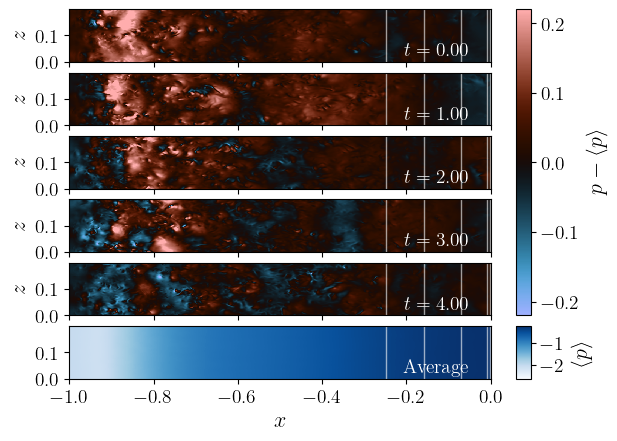

In [5]:
from matplotlib import colors
# norm = colors.Normalize(vmin=np.min(np.stack([p_ss0,p_ss1,p_ss2,p_ss3,p_ss4])), vmax=np.max(np.stack([p_ss0,p_ss1,p_ss2,p_ss3,p_ss4])))
norm = colors.Normalize(vmin=-0.22, vmax=0.22)

# Plotting
def formatter(x, pos, scale):
    return f'{x*scale:.1f}'

fig, ax = plt.subplots(6,1, sharex=True)
X , Y = np.meshgrid(x_ss[:,0], z_ss[0,:])
c = ax[0].pcolormesh(X,Y,p_ss0.T,shading='nearest', cmap='berlin', norm=norm)
ax[1].pcolormesh(X,Y,p_ss1.T,shading='nearest', cmap='berlin', norm=norm)
ax[2].pcolormesh(X,Y,p_ss2.T,shading='nearest', cmap='berlin', norm=norm)
ax[3].pcolormesh(X,Y,p_ss3.T,shading='nearest', cmap='berlin', norm=norm)
ax[4].pcolormesh(X,Y,p_ss4.T,shading='nearest', cmap='berlin', norm=norm)
c_avg = ax[5].pcolormesh(X,Y,2*(p_avg_ss.T-p_ref/p_dyn),shading='nearest', cmap='Blues')
ax[5].text(0.95, 0.05, 'Average', color='white', ha='right', va='bottom', transform=ax[5].transAxes)
for i, a in enumerate(ax[:-1]):
    a.text(0.95, 0.05, '$t={0:.2f}$'.format(dt*i*spacing), color='white', ha='right', va='bottom', transform=a.transAxes)
    a.set_ylabel(r'$z$')
    for i in range(1,6):
        a.axvline(x_ss[-dx*i,0], color='white', alpha=0.6, linewidth=1.0)

for i in range(1,6):
        ax[5].axvline(x_ss[-dx*i,0], color='white', alpha=0.6, linewidth=1.0)

ax[-1].set_xlabel(r'$x$')

fig.colorbar(c, ax=ax[:-1], orientation='vertical', fraction=.1, label=r'$p-\langle p\rangle$')
fig.colorbar(c_avg, ax=ax[-1], orientation='vertical', fraction=.1, aspect=3.5, label=r'$\langle p\rangle$')
plt.show()



The figure shows the instantaneous pressure distribution over the suction side (i.e. the top side) at four different time steps. The turbulent fluctuations can be considered stationary in time, as well as the span-wise $z$ direction (because of the periodic boudary conditions). However, it is clear that this is not the case in the chord-wide $x$ direction. Many different phenomena occur along the chord, which change the statistical properties of the turbulent distrurbances. We can thus concentrate on strips at constant $x$ (indicated by the vertical lines), and try to generate pressure at these fixed locations. 

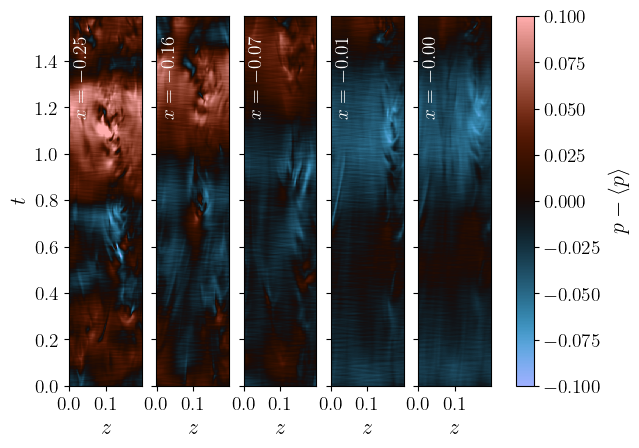

In [6]:
fig,ax = plt.subplots(1,5, sharey=True)
X , Y = np.meshgrid(z_ss[0,:], np.arange(n_steps)*dt)
# norm = colors.Normalize(vmin=np.min(np.stack([p_te0,p_te1,p_te2,p_te3,p_te4])), vmax=np.max(np.stack([p_te0,p_te1,p_te2,p_te3,p_te4])))
norm = colors.Normalize(vmin=-0.1, vmax=0.1)
c = ax[4].pcolormesh(X,Y,p_te0,shading='nearest', cmap='berlin', norm=norm)
ax[3].pcolormesh(X,Y,p_te1,shading='nearest', cmap='berlin', norm=norm)
ax[2].pcolormesh(X,Y,p_te2,shading='nearest', cmap='berlin', norm=norm)
ax[1].pcolormesh(X,Y,p_te3,shading='nearest', cmap='berlin', norm=norm)
ax[0].pcolormesh(X,Y,p_te4,shading='nearest', cmap='berlin', norm=norm)
for i, a in enumerate(ax[::-1]):
    a.text(0.05, 0.95, '$x={0:.2f}$'.format(x_ss[-dx*(i+1),0]), color='white', ha='left', va='top', transform=a.transAxes, rotation=90)
    a.set_xlabel(r'$z$')

ax[0].set_ylabel(r'$t$')
fig.colorbar(c, ax=ax, orientation='vertical', fraction=.1, label=r'$p-\langle p\rangle$')


plt.show()

These are chunks of about 1/10 the size of the full dataset. The pressure fluctuations can be considered stationary both in time and in $z$. You can also see a big structure moving across the airfoil: the red spot that moves upwards moving from left to right, which means that is is being advected with the flow. 